In [3]:
import matplotlib
from matplotlib import pylab
%config InlineBackend.figure_format = 'retina'
matplotlib.rcParams['figure.dpi'] = 80
params = {'legend.fontsize': 'xx-large',
          'figure.figsize': (6, 4),
         'axes.labelsize': 'xx-large',
         'axes.titlesize': 'xx-large',
         'xtick.labelsize': 'x-large',
         'ytick.labelsize': 'x-large',
         'figure.facecolor': 'w'}
pylab.rcParams.update(params)
from matplotlib import pyplot as plt
import matplotlib.gridspec as gridspec

import h5py
import numpy as np
import sys

sys.path.insert(1, '../code')
from featurize_and_fit import Featurizer, Fitter
import plotter
import scalars

%load_ext autoreload
%autoreload 2

## Load data

In [5]:
y_scalar_feature_name='mass_hydro_subhalo_star'

In [2]:
mass_multiplier = 1e10

In [3]:
base_dir = '/scratch/ksf293/equivariant-cosmology/data'
sim_name_50 = 'TNG50-4'
sim_name_100 = 'TNG100-1'
snap_num_str = '099' # z = 0

In [6]:
featurizer_50 = Featurizer(base_dir, sim_name_50, snap_num_str)
featurizer_50.load_halo_dicts(num_star_particles_min=1, halo_mass_min=10**10.8,
                           halo_mass_min_str='1e10.8', halo_mass_difference_factor=3.0,
                           force_reload=False)
featurizer_50.set_y_labels(y_scalar_feature_name=y_scalar_feature_name)

Halo file ../data/halo_dicts_TNG50-4_nstarmin1_hmassmin1e10.8_mdifffac3.0.npy exists, loading


In [8]:
featurizer_100 = Featurizer(base_dir, sim_name_100, snap_num_str)
featurizer_100.load_halo_dicts(num_star_particles_min=1, halo_mass_min=10**10.8,
                           halo_mass_min_str='1e10.8', halo_mass_difference_factor=3.0,
                           force_reload=False)
featurizer_100.set_y_labels(y_scalar_feature_name=y_scalar_feature_name)

Halo file ../data/halo_dicts_TNG100-1_nstarmin1_hmassmin1e10.8_mdifffac3.0.npy exists, loading


In [13]:
# Inputs to SHMR broken power law:
# N: the normalization of the SHM ratio 
# M1: a characteristic mass 
# β and γ: indicate the behavior of m/M at the low and high-mass ends
def broken_power_law_byeye(M200, N=0.01, M1=1e12/mass_multiplier, beta=1.5, gamma=0.4):
    return M200*2*N/((M200/M1)**(-beta) + (M200/M1)**gamma)

In [14]:
# defaults are best-fit values from Engler+2020
def broken_power_law_engler(logMdyn, N=0.0258, logM1=11.70, beta=28.6, gamma=10.4):
    return 10**logMdyn * 2*N/((logMdyn/logM1)**(-beta) + (logMdyn/logM1)**gamma)

In [25]:
M = np.logspace(10, 14, 100)
m_byeye = broken_power_law_byeye(M/mass_multiplier)*mass_multiplier
m_engler = broken_power_law_engler(np.log10(M))

In [34]:
m200_50 = np.array([h['mass_mean200_dark_halo_dm'] for h in featurizer_50.halo_dicts])*mass_multiplier
m_stellar_50 = featurizer_50.y_scalar*mass_multiplier

In [37]:
m200_100 = np.array([h['mass_mean200_dark_halo_dm'] for h in featurizer_100.halo_dicts])*mass_multiplier
m_stellar_100 = featurizer_100.y_scalar*mass_multiplier

Text(0, 0.5, '$M_\\mathrm{galaxy}$')

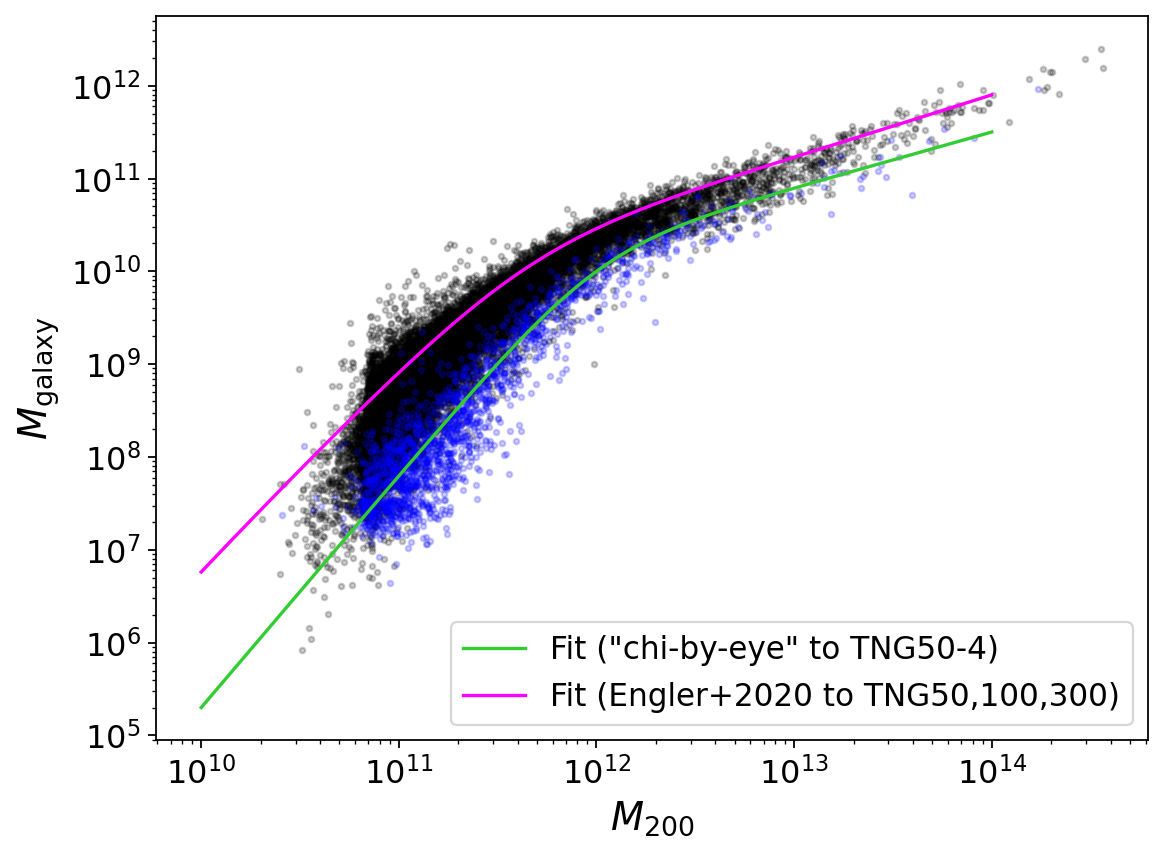

In [42]:
plt.figure(figsize=(8,6))

plt.scatter(m200_100, m_stellar_100, c='k', alpha=0.2, s=6)
plt.scatter(m200_50, m_stellar_50, c='b', alpha=0.2, s=6)

plt.plot(M, m_byeye, color='limegreen', label='Fit ("chi-by-eye" to TNG50-4)')
plt.plot(M, m_engler, color='magenta', label='Fit (Engler+2020 to TNG50,100,300)')

plt.xscale('log')
plt.yscale('log')
plt.legend(fontsize=14)

plt.xlabel(r'$M_{200}$')
plt.ylabel(r'$M_\mathrm{galaxy}$')

Note: Engler+2020 actually uses Mdyn, dynamical mass! Can't figure out how to get.

Note: This is for just the matched subhalos, so it will be a subset of all, but it should only include centrals.

## Uncertainties

From Genel+2019 Figure 8, upper right panel:

In [8]:
logmstellar_bins = np.arange(8.5, 11.5, 0.5)
stdev_dict = {'TNG50-4': np.array([0.28, 0.23, 0.12, 0.05, 0.04]), # epsilon=4, similar to tng50-4
              'TNG100-1': np.array([0.08, 0.06, 0.04, 0.03, 0.04]), # epsilon=1, similar to tng100-1
             }